__Tips: Please install Bio before running by:__
pip install biopython

## Structure:
<img src='image/process2.png'>
<img src='image/process.png'>

In [1302]:
# python3 genome_simulation.py --ini='bacteria.ini' --data='Escherichia_coli_DH10B.fasta'
from configparser import ConfigParser
import optparse
import random, os, sys
import pandas as pd

import logging
from datetime import datetime
import numpy as np
import calendar
import time
from Bio import SeqIO 
from decimal import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import pairwise_distances

pd.options.display.max_columns = None

#### Step 0. Please configure these parameters accordingly before running:
- ALL parameters in configuration will be kept in the format of 'conf_XXXXX' for easily recognization.
- __For [dendrogram]:__
    - linkage_method: 'single', 'weighted', 'average', 'centroid', 'median', 'ward'
    - metric: pdist: 'euclidean', 'minkowski', 'cityblock'(manhattan), 'seuclidean', 'cosine', 'correlation', 'hamming', 'canberra', 'jaccard', 'chebyshev', 'canberra', 'braycurtis', 'yule', 'matching' etc.
    - REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html;   
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

In [1303]:
#[lamba]
# conf_lamba_min/max: It is on a per generation basis ... update mutation rate to different values within the rage. 
# conf_lamba_min/max:Start by one generation the min rate then the next the max rate then the min rate etc
# conf_lamba_min=0.1 
# conf_lamba_max=0.5

lambda_vary_type = 0      # 0: constant mode; 1: Random within range 1; 2: alternating min-max-min-max-min-max 
conf_lamba_constant = 0.1 # Configure this only if constant mode
conf_lamba_min=0.1        # Configure min, max only for alternating min-max way.
conf_lamba_max=0.5        # Configure min, max only for alternating min-max way.
conf_generation=7

#[mutation]
conf_run_times=90 # run_times: How many mutated seqs will be generated.
conf_numrows=1

#[fasta]
conf_filepath = '../Escherichia_coli_DH10B.fasta' # The path of fasta file.
conf_top_num = 40 # How many bases could be kept from fasta file.s

# conf_generated_file_format: specify the format will be generated with: '.nex','.txt' etc.
conf_generated_file_format = '.txt'

# [pdist]
if_add_hamming = 0 # 1: Add hamming distance as the column for pdist & dendrogram; 0: Remove hamming distance for dendrogram;


# For VARYING LAMBDA:
#1  alternating min-max-min-max-min-max
#2. Random within range
#3. Constant lambda (done)

#[dendrogram]
linkage_method = 'median'         # 'single', 'weighted', 'average', 'centroid', 'median', 'ward'
pdistance_method =  'hamming' #  'euclidean', 'minkowski', 'cityblock'(manhattan), 'seuclidean', 'correlation', 'hamming', 'canberra', 'jaccard', 'chebyshev', 'canberra', 'braycurtis', 'yule', 'matching' etc.

#### Step 1. Function definition:
__A. parse_file(filename, formatname, length):__ Return the sequencing from file with specified format and length.  
__B. mutate_prob(target_bases_list, prob):__ Mutate the base by picking from bases list with probability.  
__C. mutation_simulate(ori_seq):__ Mutate the original sequencing by probability/flipping and return the mutated sequencing, and how many bases have been mutated.

In [1304]:
def parse_file(filename, formatname, length): 
    '''
        filename: file path
        formatname: 'fasta', 'abi', 'genbank or gb' etc...
        length: top number for snipping
    '''
    with open(filename, "rU") as handle:
        for record in SeqIO.parse(handle, formatname) :
            if len(record.seq)>length:
                base_top = record.seq[:length]
        return record, base_top

In [1305]:
#Get hamming distance of 2 strings:
def hamming(str1, str2):
    return sum(str1 != str2 for str1, str2 in zip(str1, str2))

In [1306]:
def mutate_base(ori_base, conf_lamba, bases_pool_list): #['C','A','G']
    
    mutated_base = np.random.choice(bases_pool_list, 1, [1-conf_lamba, conf_lamba/2, conf_lamba/2]) #Pick 1 from target list based on flip.
    return mutated_base

In [1307]:
def mutation_simulate(ori_seq, conf_lamba, lambda_vary_type):
    mutated_seq = []
    current_lambda = 0

    if lambda_vary_type == 0: #constant lambda
        print('Constant: ', conf_lamba)
        for ori_base in ori_seq:         
            #print(time, 'ori_base: ', ori_base)
            
            if ori_base == 'A' or ori_base == 'T':
                mutated_seq.append(ori_base)
            
            if ori_base == 'C': #C-> G or A
                mutated_seq.append(mutate_base(ori_base, conf_lamba, ['C','A','G']))      
                
            # For G base: transit to C or T by flip probability (if flip < lamda picked randomly from configuration lambda list.)       
            elif ori_base == 'G': #G-> C or T
                mutated_seq.append(mutate_base(ori_base, conf_lamba, ['G','C','T']))

    elif lambda_vary_type == 1: # Random
        conf_lamba = 0
        current_lambda = np.random.uniform(0, 1) 
        print('Random: ', current_lambda)
        
        for ori_base in ori_seq:         
            if ori_base == 'A' or ori_base == 'T':
                mutated_seq.append(ori_base)
            
            if ori_base == 'C': #C-> G or A
                mutated_seq.append(mutate_base(ori_base, current_lambda, ['C','A','G']))      
                
            # For G base: transit to C or T by flip probability (if flip < lamda picked randomly from configuration lambda list.)       
            elif ori_base == 'G': #G-> C or T
                mutated_seq.append(mutate_base(ori_base, current_lambda, ['G','C','T']))
                
                             
    return mutated_seq

In [1308]:
def mutation_simulation_alternating_min_max(ori_seq, lambda_list):
    mutated_seq = []
    lambda_list = sorted([float(conf_lamba_min), float(conf_lamba_max)])
    print('Alternating min-max: ', lambda_list)
        
    for index in range(len(ori_seq)):                   
        # For C base: transit to A or G by flip probability (if flip < lamda picked randomly from configuration lambda list.)
        if index%2==0:        # Even index: use min lambda
            current_lambda = lambda_list[0]
            ori_base = ori_seq[index]
            #print('min: ', current_lambda)

            if ori_base == 'A' or ori_base == 'T':
                mutated_seq.append(ori_base)
            
            if ori_base == 'C': #C-> G or A
                mutated_seq.append(mutate_base(ori_base, current_lambda, ['C','A','G']))      
                
            # For G base: transit to C or T by flip probability (if flip < lamda picked randomly from configuration lambda list.)       
            elif ori_base == 'G': #G-> C or T
                mutated_seq.append(mutate_base(ori_base, current_lambda, ['G','C','T']))
            
        else:                           # Odd index: use max lambda
            current_lambda = lambda_list[1]
            #print('max: ', current_lambda)
                
            if ori_base == 'A' or ori_base == 'T':
                mutated_seq.append(ori_base)
            
            if ori_base == 'C': #C-> G or A
                mutated_seq.append(mutate_base(ori_base, current_lambda, ['C','A','G']))      
                
            # For G base: transit to C or T by flip probability (if flip < lamda picked randomly from configuration lambda list.)       
            elif ori_base == 'G': #G-> C or T
                mutated_seq.append(mutate_base(ori_base, current_lambda, ['G','C','T']))
    return mutated_seq

#### Step 2: Get the specified length of the sequences from the specified file.

In [1309]:
# Get the trimmed seq string from specified file.
record, base_top = parse_file(conf_filepath, "fasta", int(conf_top_num))
ori_seq = str(base_top)
print(ori_seq)

c:\python37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 'U' mode is deprecated
  import sys


AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG


#### Step 3: Generate the mutated sequences with specified times and write these mutated sequeces to file with specified format.
- In this case, write the mutated sequeces in .nex file.  
- The file will be named with timestamp.  
- e.g.: __Generated file: GBAC_<Generation\><mutation_rate\>Seq__  
GBAC_7_0.2 AGCTTTTCATTCTGACTGAAACGGGCAATATGTCTCTGTG  
GBAC_7_0.2 AGATTTTCATTCTGACTGCAACGGTCAATATGTCTCTGTG  
GBAC_7_0.2 AGCTTTTCATTCTGACTGCAACGCGCAATATTTCTATCTC  
GBAC_7_0.2 AGATTTTCATTCTGACTTCAACGCGAAATATGTCTCTGTG  
GBAC_7_0.2 AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG  

In [1310]:
# Generate file name with timestamp.
timestamp = calendar.timegm(time.gmtime())
print(timestamp)
mut_seq_nexfilepath = "file_generated\\"+"SimSeqFile_"+ str(timestamp) + conf_generated_file_format

1565827351


#### Step 4: Generate the sequences and differences for output file.

In [1311]:
# Sike:
def dna_seq_compare(ori_seq, mutated_seq):
    len1 = len(ori_seq)
    len2 = len(mutated_seq)
    
    mismatches = []
    diff_pos = []
    
    for pos in range (0, min(len1, len2)):
        if ori_seq[pos]!= mutated_seq[pos]:
            mismatches.append("|")
            diff_pos.append(pos)
        else:
            mismatches.append(" ")
    mismatches = "".join(mismatches)
    
    return diff_pos, mismatches+'\n'+ mutated_seq

In [1312]:
# Create dataframe to store all seqs (original and mutated), hamming distance and the specific difference.
multi_mutated_seq=''
diff_str = ''
multi_mutated_seq ='>Ori\n' + ori_seq+'\n'

list_all_hamming = []

for i in range(0, len(ori_seq)):
    list_all_hamming.append(str(i))
    
df_mutseq_hamming = pd.DataFrame(columns=["id", "seq", "hamming_distance"]+list_all_hamming).append({"id":0,"seq":ori_seq, "hamming_distance":0},ignore_index=True)
df_mutseq_hamming.fillna(0) # Fill the nan value with 0.


,id,seq,hamming_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1313]:
# Generate the mutated seq, hamming distance, and mark the difference between mutated seqs and original sequence.
# Generate the dataframe with mutated seq and hamming distance.

if lambda_vary_type == 0:
    current_lambda = conf_lamba_constant
    print('Constant: ', current_lambda)

elif lambda_vary_type == 1: # Random
    current_lambda = np.random.uniform(0, 1) 
    print('Random: ', current_lambda)

elif lambda_vary_type == 2: # Alternating
    lambda_list = sorted([float(conf_lamba_min), float(conf_lamba_max)])
    print('Alternating min-max: ', lambda_list)
 

Constant:  0.1


In [1314]:
for run_time in range(conf_run_times): 
    if lambda_vary_type==1 or lambda_vary_type==0:
        mutated_seq = mutation_simulate(ori_seq, current_lambda, lambda_vary_type)
    
    elif lambda_vary_type==2:
         mutated_seq = mutation_simulation_alternating_min_max(ori_seq, lambda_vary_type)   
   
    mutated_seq_str = ''.join([''.join(base) for base in mutated_seq])
    
    #seq_num s= 'GBAC_' + str(conf_generation)+'_'+ str(conf_lamba)
    multi_mutated_seq += '>Gen'+str(conf_generation)+'_'+str(run_time)+'\n'+mutated_seq_str+'\n'
    hamming_distance = hamming(ori_seq, mutated_seq_str)
    print('Hamming distance: ', hamming_distance)
    
    df_mutseq_hamming = df_mutseq_hamming.append({"id":run_time+1, "seq":mutated_seq_str, "hamming_distance": hamming_distance},ignore_index=True) 

    diff_str += str(run_time+1)+' time(s) mutation: '+ str(dna_seq_compare(ori_seq, mutated_seq_str)[0])+'\n'
    
    #Sike: diff marker:
    print(ori_seq)
    
    str_diff_result = dna_seq_compare(ori_seq, mutated_seq_str)[1]+'\n'+'_______________________________________'   
    list_diff_result = dna_seq_compare(ori_seq, mutated_seq_str)[0]
    
    print(str_diff_result)
    
    for diff in list_diff_result:
        #print('diff: ', diff)
        df_mutseq_hamming.set_value(run_time+1, str(diff), 1)

Constant:  0.1
Hamming distance:  8
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
       |     |   ||      |     |   | |  
AGCTTTTAATTCTCACTCGAACGGGAAATATCTCTATTTG
_______________________________________
Constant:  0.1
Hamming distance:  13
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
  |    |   | | | |    || |     |   | | |
AGATTTTAATTGTTAGTTCAACCCGGAATATCTCTATTTT
_______________________________________
Constant:  0.1
Hamming distance:  11
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
  |    |   |   |  |    |||         | | |
AGGTTTTGATTATGAATGAAACGTCGAATATGTCTGTCTT
_______________________________________
Constant:  0.1
Hamming distance:  9
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
       |   | |   ||     |        |   | |
AGCTTTTGATTATTACTTGAACGGTCAATATGTATCTCTT
_______________________________________
Constant:  0.1
Hamming distance:  14
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
 ||    |   | | | ||  || ||         |   |
ATGTTTTAATTATCAGTCAAAGTGCAAATATGTCTGTGTC
_______________________________________
Co

c:\python37\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
 ||          |       || ||     | | | | |
ATATTTTCATTCTTACTGCAAATGCGAATATTTGTATTTT
_______________________________________
Constant:  0.1
Hamming distance:  10
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
  |    |   |   | |   |  |        | | |  
AGGTTTTAATTGTGAGTCCAAAGGCCAATATGTATATCTG
_______________________________________
Constant:  0.1
Hamming distance:  12
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
  |        | | | ||    ||      | |   | |
AGGTTTTCATTGTCAATCGAACGTCCAATATTTATCTCTC
_______________________________________
Constant:  0.1
Hamming distance:  7
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
 ||        |         |           | |   |
ACATTTTCATTGTGACTGCAAGGGGCAATATGTGTATGTT
_______________________________________
Constant:  0.1
Hamming distance:  17
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
 ||    |   | | | |   |||||     | | | | |
ATATTTTAATTATCAGTTCAAACCTGAATATTTGTGTTTC
_______________________________________
Constant:  0.1
Hamming distance:  13
A

Hamming distance:  14
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
 ||    |   | |   ||  | | |     | | |   |
ATGTTTTAATTATTACTTAAAAGTGGAATATTTGTATGTC
_______________________________________
Constant:  0.1
Hamming distance:  16
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
 ||    |   | | | ||  ||||      | |   | |
ACATTTTAATTGTTAATCGAAATCTCAATATTTGTCTCTC
_______________________________________
Constant:  0.1
Hamming distance:  10
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
  |    |   | | |      ||           | | |
AGATTTTAATTGTCAATGCAACTTGCAATATGTCTGTTTC
_______________________________________
Constant:  0.1
Hamming distance:  10
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
  |          |   ||  |||       |   |   |
AGGTTTTCATTCTCACTCGAAGTCGCAATATTTCTGTGTT
_______________________________________
Constant:  0.1
Hamming distance:  9
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
 |             |      |  |     | | | | |
ACCTTTTCATTCTGAGTGCAACTGGGAATATTTGTATTTT
_______________________________________
Constant:  0.1
H

In [1315]:
def write_file(filepath, content):
    with open(filepath, "w") as file:
        file.write(content)
        print('Done. Wrote to: ', filepath)

In [1316]:
write_file(mut_seq_nexfilepath, multi_mutated_seq+'\n')

Done. Wrote to:  file_generated\SimSeqFile_1565827351.txt


In [1317]:
diff_filepath = "file_generated\\"+"Diff_Ori_Mut_"+ str(timestamp) + conf_generated_file_format # Leave this para
write_file(diff_filepath, diff_str)

Done. Wrote to:  file_generated\Diff_Ori_Mut_1565827351.txt


In [1318]:
#Generate the dataframe with hamming distance.
df_mutseq_hamming = df_mutseq_hamming.fillna(0)
df_mutseq_hamming

,id,seq,hamming_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,AGCTTTTAATTCTCACTCGAACGGGAAATATCTCTATTTG,8,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,2,AGATTTTAATTGTTAGTTCAACCCGGAATATCTCTATTTT,13,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1
3,3,AGGTTTTGATTATGAATGAAACGTCGAATATGTCTGTCTT,11,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
4,4,AGCTTTTGATTATTACTTGAACGGTCAATATGTATCTCTT,9,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
5,5,ATGTTTTAATTATCAGTCAAAGTGCAAATATGTCTGTGTC,14,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6,6,ACCTTTTGATTGTGAGTCCAAAGGTGAATATGTGTGTTTG,11,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0
7,7,AGATTTTGATTGTGAATGGAAGTTGAAATATTTGTGTGTT,13,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1
8,8,AGATTTTAATTCTTAATGCAAGGTCAAATATCTCTCTCTT,11,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1
9,9,AGGTTTTAATTGTCAATCCAAGCGCAAATATTTATATCTC,15,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1


#### Step 5: Clustering:

#### scipy.cluster.hierarchy.linkage():
- The following linkage methods are used to compute the distance d(s, t) between two clusters s and t. 
- The following are methods for calculating the distance between the newly formed cluster u and each v:
     - method=’single’ assigns
     - method=’complete’ assigns
     - method=’average’ assigns
     - method=’centroid’ assigns
     - method=’median’ assigns
     - method=’ward’ 

#### Note:   
The resulting matrix Z is informing each step of the agglomerative clustering by informing the first two columns of which cluster indices were merged.  
The third column is the distance between those clusters, and the fourth column is the number of original samples contained in that newly merged cluster. 

-  it is necessary to group similar genes.

### Visualizing the clusters:

- A good way to visualise this is with a dendrogram, which shows at which inter-cluster distance each merge occurred.  
From there, it is possible to select a distance where clusters are clear (indicated with the horizontal black lines).

In [1319]:
df_mutseq_hamming.head(4)

,id,seq,hamming_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,AGCTTTTAATTCTCACTCGAACGGGAAATATCTCTATTTG,8,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,2,AGATTTTAATTGTTAGTTCAACCCGGAATATCTCTATTTT,13,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1
3,3,AGGTTTTGATTATGAATGAAACGTCGAATATGTCTGTCTT,11,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1


In [1320]:
array_mutseq_hamming = df_mutseq_hamming.iloc[:,2:].values #Get hamming distance from df.
list_mutseq_seq = list(df_mutseq_hamming['seq']) 

In [1321]:
# Find the distance information.
df_remove_seq = df_mutseq_hamming.iloc[:,2:]
df_remove_seq.head(4)

,hamming_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,13,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1
3,11,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1


In [1322]:
# if_add_hamming:set this in parameters settings.
# if_add_hamming==0: remove 'hamming_distance' for further dendrogram;
# if_add_hamming==1: keep 'hamming_distance' for further dendrogram;

if if_add_hamming == 0:
    df_remove_seq = df_mutseq_hamming.iloc[:,3:]

df_remove_seq.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1
3,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1


#### Get the pairwise distance matrix:
- Pairwise distance between observations, by returning a condensed distance matrix Y.   
__scipy.spatial.distance.pdist(X, metric='XX', *args, **kwargs):__  
   - Pairwise distances between observations in n-dimensional space:
   - __X__:  
       An m by n array of m original observations in an n-dimensional space.
   - __metric:__  
       The distance metric to use. The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

In [1323]:
df_remove_seq_pdist = pdist(df_remove_seq, pdistance_method) # Set pairwisedistance_method in the parameter session.
print(df_remove_seq_pdist)
print(len(df_remove_seq_pdist))

[0.2   0.325 0.275 ... 0.075 0.275 0.3  ]
4095


#### Get linkage:
- __scipy.cluster.hierarchy.linkage(y, method='single', metric='euclidean', optimal_ordering=False):__  
    Perform hierarchical/agglomerative clustering.
- __y__:  
    - a. 1d condensed distance matrix;
    - b. a 2d array of observation vectors.
 

In [1324]:
linked = linkage(df_remove_seq_pdist, linkage_method) 

- Note:  
    linkage parameter is set to "ward" or other linkage_method defined on the parameters session, which minimizes the variant between the clusters.

#### Check the Cophenetic Correlation Coefficient to assess quality of clusters:

In [1325]:
c, coph_dists = cophenet(linked, df_remove_seq_pdist) 
c

0.4669270030844645

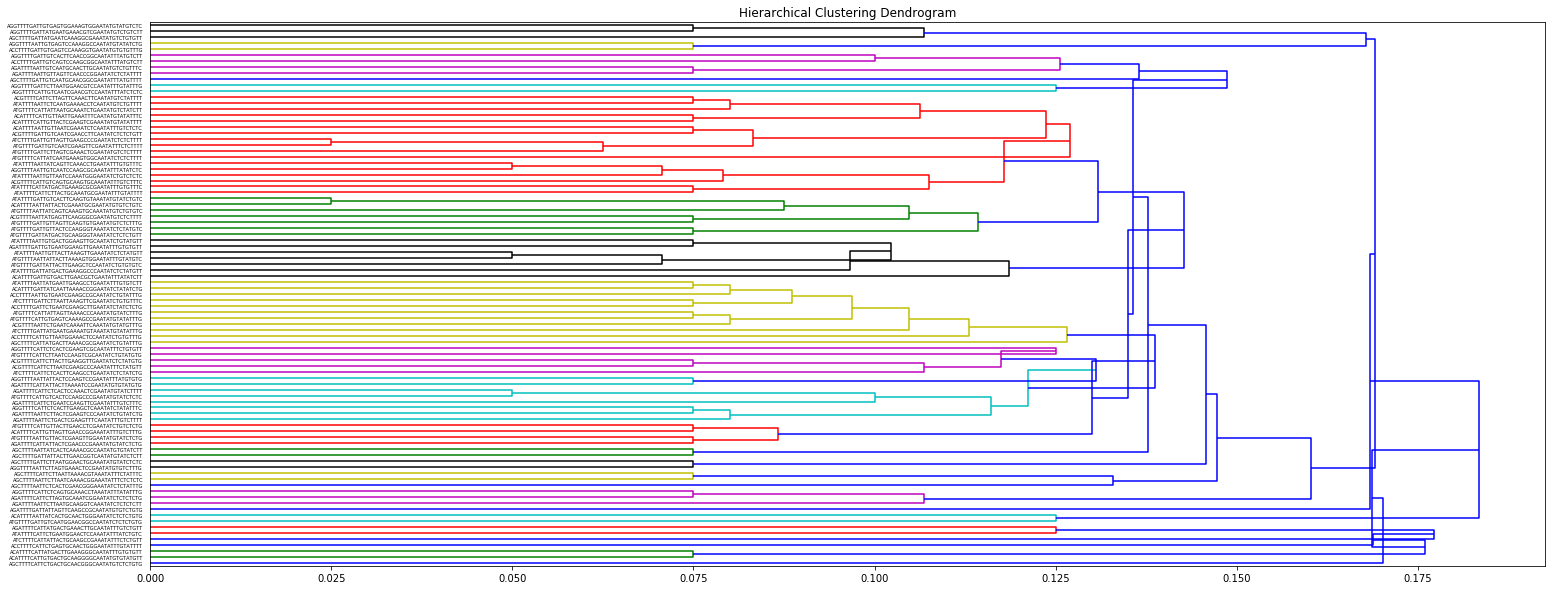

In [1326]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')

labelList = list_mutseq_seq

dendrogram(
            linked,
            orientation='right',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True
          )
plt.show()

- Note:
    - That height is the distance between the two subclusters that are merged by that link. 

### Reference:
- Hamming distance: https://people.revoledu.com/kardi/tutorial/Similarity/HammingDistance.html
- Hamming distance: https://github.com/ozcan/scipy-cluster/blob/master/old/cluster.py
- Hamming distance: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.hamming.html
- Hierarchical Clustering with Python and Scikit-Learn https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/